# „Short term performance of female vs male directors‘ dealings in shares of Nasdaq Composite Index companies in the period 2000 - 2023“
### Interdisciplinary Project: Annabel Resch, 11914287


## Table of Contents

[Step 1: Data Import](#step1)  
•⁠  ⁠[Download all data from website](#download)  
•⁠  ⁠[Data preprocessing](#prepro)  
•⁠  ⁠[Explorative Analysis](#explo)  

[Step 2: Director Classification](#step2)  
•⁠  ⁠[Explorative Analysis: Gender Distribution](#eda)

[Step 3 and 4: Calculate Abnormal Returns (AR)](#step3)  
•⁠  ⁠[Import and preprocess daily company and market returns](#pp_dr)    
•⁠  ⁠[Calculate Abnormal Returns](#calcAR)  
•⁠  ⁠[EDA: AR and CAR](#edaAR)

[Step 5: Statistical Hypothesis Testing](#sttest)  
•⁠  ⁠[Gender Study](#descr)  
•⁠  ⁠[Analyze Titles](#titles)  
•⁠  [CAAR Visualizations](#vis)

In [1]:
import os
import pandas as pd
import pickle
import numpy as np
import warnings
import seaborn as sns
import re
from names_dataset import NameDataset
import time
import datetime 
import import_data
import matplotlib.pyplot as plt
import gender_classification
import calculate_AR
from scipy.stats import skew, kurtosis
from eventstudystatistics import adjBMP, adjBMP_daily, grank
from IPython.display import clear_output

path = "/Users/admin/Documents/IP/data/"

RUN_IMPORT = False
RUN_PREPROCESSING = False 
RUN_CLASSIFICATION = False
RUN_DAILY_RETURNS = False
RUN_Calc_AR = False
RUN_statistics = False

warnings.filterwarnings('ignore')

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Step 1: Data Import  <a class="anchor" id="step1"></a>

### Download all data from website <a class="anchor" id="download"></a>

We check 7669 distinct companies, which are currently or were in the past listend in the Nasdaq Composite Index.  
However, only those with listed director dealing(s) of trade type 'Sale' or 'Purchase' are added to the dataframe. 

In [2]:
if RUN_IMPORT == True:
    start_time = time.time()
    %run import_data.py
    print("--- %s minutes ---" % ((time.time() - start_time)/60))

### Preprocessing of downloaded data <a class="anchor" id="prepro"></a>

First of all, we import the 8 files containing the transactions

In [3]:
if RUN_PREPROCESSING == True: 
 
    files = os.listdir(path+"DD_download/")
    print(files)
    df = pd.DataFrame()
    
    for f in files[1:]:
        file = open(path+"DD_download/" + f, 'rb')
        data = pickle.load(file)
        file.close()
        df = pd.concat([df,data]) 

Now that we have our initial df set up, we can start analyzing the data and cleaning up the dataset.

In [4]:
isin = pd.read_excel(path+ 'Input/ISIN_merge.xlsx')
if RUN_PREPROCESSING == True: 
    # Quick quality check next
    # Drop all duplicates
    
    print("DF shape after immediate download: " + str(df.shape))
    print("Number of duplicate rows: " + str(df.duplicated().sum()))
    df.drop_duplicates(inplace=True)
    print("After deleting all duplicates: " + str(df.shape))
    
    # weirdly, all tickers start with a space 
    df.Ticker = df.Ticker.str[1:]
    
    print("Ticker is empty: "+str(df["original_Ticker"].isna().sum())) 
    tickers_input = isin['TICKER SYMBOL'].tolist()
    #print(len(TICKERS))
    
    tickers_output = df.Ticker.unique().tolist()
    no_DD = list(set(tickers_input) - set(tickers_output))
    pd.DataFrame(no_DD).to_excel(path+"report/Ticker_No_DD.xlsx")
    print("\n"+"No director dealing found: " + str(len(no_DD)))
    print("\n"+"Unique tickers in output download: " + str(len(tickers_output)))
    print("\n"+"Unique tickers in input excel: " + str(len(tickers_input)))

We have a large number of tickers in the df that are not in the original set, because the ticker name has changed over the years.
For that reason, I've added another column with the original ticker to the df during the import. 
After alignment with Prof. Aussenegg, I will drop all transactions, where OG Ticker != website Ticker! 

In [5]:
if RUN_PREPROCESSING == True: 

    not_in_list = list(set(tickers_output)-set(tickers_input))
   
    print("\n"+"Number of tickers that were not in the original list: " + str(len(not_in_list)))
    pd.DataFrame(not_in_list).to_excel(path+"report/Ticker_notin_OG.xlsx")
    
    print("\n"+"Before deleting Ticker mismatches: " + str(df.shape))
    ticker_mismatch = df[df["original_Ticker"] != df["Ticker"]]
    ticker_mismatch.to_excel(path+"report/tickers_deleted_notOG.xlsx")
    #just to be on the safe side both xlsx should be identical
    
    df = df[df["original_Ticker"] == df["Ticker"]]
    print("After deleting Ticker mismatches: " + str(df.shape))
    

But we have 2455 tickers in total with Ticker != OG Ticker. Because even if the Ticker is found in the original list, it is now assigned also to another transaction, that was originally done by another Ticker (e.g. NMRT). So we have 350 Tickers that are og tickers for some transaction but also appear as incorrect tickers for other transactions.

Okay, all unnecessary rows are deleted, now let's delete columns that we don't need.

In [6]:
if RUN_PREPROCESSING == True:    
    
# Let's see how many companies we have left with a DD
    
    print("\n"+ "Out of " + str(len(tickers_input))+" initial companies, " + str(len(set(df.Ticker.tolist()))) +" have listed a directors' Sale' or 'Purchase'.")
    
# We only keep columns with valuable information

    df.columns = ['X', 'Filing Date' , 'Trade Date','Ticker','Insider Name','Title','Trade Type',
     'Price','Qty','Owned','ΔOwn',"Value",'1d','1w','1m','6m','original_Ticker','Company Name']
    df = df[[ 'Filing Date', 'Trade Date', 'Ticker', 'Insider Name', 'Title', 'Trade Type','Price','Qty','Owned','ΔOwn',"Value"]]

# Save the preprocessed file
    df.to_pickle(path+"Transactions_preprocessed.pkl")

else: 
    df = pd.read_pickle(path+"Transactions_preprocessed.pkl")

In [7]:
df.head(3)

,Filing Date,Trade Date,Ticker,Insider Name,Title,Trade Type,Price,Qty,Owned,ΔOwn,Value
0,2022-03-25 16:36:22,2021-12-02,SATS,Wade William David,Dir,P - Purchase,$27.03,+443,443,New,"+$11,974"
1,2022-03-14 16:39:07,2022-03-10,SATS,Dodge R Stanton,Dir,P - Purchase,$24.17,"+20,500","21,011",>999%,"+$495,485"
2,2021-03-01 18:39:03,2021-02-25,SATS,Johnson Anders N,"CSO, Pres - ESS",P - Purchase,$23.45,"+20,000","23,064",+653%,"+$469,000"


We need to add the ISIN Code for each company, because that will be used as unique key when joining with the daily return data. 

In [8]:
df = df.merge(isin,left_on="Ticker", right_on="TICKER SYMBOL", how='left').drop(columns="TICKER SYMBOL")

In [9]:
not_found = df[df["ISIN CODE"].isna()]
print("Transactions without ISIN Code: " +str(len(not_found))+ ". TICKERS: " + str(not_found["Ticker"].unique()))
df.dropna(subset=['ISIN CODE'], inplace=True)

Transactions without ISIN Code: 6. TICKERS: ['PBBI']


Only one Ticker 'PBBI' cannot be matched to an ISIN code. Those transactions will be disregarded in the analysis.

Data Quality check: If several DD of the same type and of the same person take place on the same day, then these transactions
should be condensed to one transaction.  
We need to normalize the filing date for that first. Thus, we drop the time and only keep the date. 

In [10]:
df["Filing Date"] = df['Filing Date'].apply(lambda x: pd.to_datetime(x).normalize())
df[df.duplicated(subset=['Filing Date', 'Insider Name','Ticker','Trade Type'],keep=False)].to_excel(path + "report/DD_sameDayPerson.xlsx")
df.drop_duplicates(subset=['Filing Date', 'Insider Name','Ticker','Trade Type'], keep='first',inplace=True)

print(df.shape)

(601535, 12)


We have 31.304 DD of the same person on the same day, sometimes even more than 2. We are deleting 19.681 transactions. (last checked 17.02.24)

### Explorative Analysis of Transactions <a class="anchor" id="explo"></a>

Let's see how many director dealings the companies have in average.

In [11]:
x = df.groupby('Ticker')['Filing Date'].agg('count').reset_index()
print("Mean of transactions per company: "+ str(x["Filing Date"].mean()))
print("Median of transactions per company: "+ str(x["Filing Date"].median()))
print("Max number of transactions per company: "+ str(x["Filing Date"].max())+". Company ticker: "+str(x.sort_values(by="Filing Date",ascending =False)[:1].Ticker))

# To see which companies have the most transactions:
x.sort_values(by="Filing Date",ascending =False)[:5]

Mean of transactions per company: 103.30328009617035
Median of transactions per company: 48.0
Max number of transactions per company: 8978. Company ticker: 2746    ISCA
Name: Ticker, dtype: object


,Ticker,Filing Date
2746,ISCA,8978
3386,MORN,2158
5017,SYBT,1949
4275,QCOM,1945
5402,UTHR,1822


In [12]:
print(x.sort_values(by="Filing Date",ascending =False)[:5].to_latex(index=False,formatters={"name": str.upper},float_format="{:.1f}".format))

\begin{tabular}{lr}
\toprule
Ticker &  Filing Date \\
\midrule
  ISCA &         8978 \\
  MORN &         2158 \\
  SYBT &         1949 \\
  QCOM &         1945 \\
  UTHR &         1822 \\
\bottomrule
\end{tabular}



## Step 2: Director Classification <a class="anchor" id="step2"></a>

In this step, we classify the directors into male or female, based on the directors’ name. The gender will be saved in a new column  "Gender".

In [13]:
if RUN_CLASSIFICATION == True:
    start_time = time.time()    
    
    names = df['Insider Name'].unique()
    print("Number of unique names: " + str(len(names)))
    
    gender_all = gender_classification.classify(names)
    
    df["Gender"] = df["Insider Name"].apply(lambda x: gender_all.get(x))
        
    df.to_pickle(path+"df_incl_gender.pkl")
    print("--- %s minutes ---" % ((time.time() - start_time)/60))
    
else: 
    df = pd.read_pickle(path +"df_incl_gender.pkl")
    print(df.shape)

(601535, 13)


In [14]:
df.shape

(601535, 13)

### Explorative Analysis: Gender Distribution

In [15]:
x = df.groupby('Insider Name')['Filing Date'].agg('count').reset_index()
x.sort_values(by="Filing Date",ascending =False)[:5]
print(x.sort_values(by="Filing Date",ascending =False)[:5].to_latex(index=False,formatters={"name": str.upper},float_format="{:.1f}".format))

\begin{tabular}{lr}
\toprule
                       Insider Name &  Filing Date \\
\midrule
             Frost Phillip Md Et Al &         1471 \\
                  Mansueto Joseph D &          915 \\
                Rothblatt Martine A &          793 \\
                  Kodosky Jeffrey L &          645 \\
Marxe Austin W \& Greenhouse David M &          625 \\
\bottomrule
\end{tabular}



In [16]:
gender_dist = df.drop_duplicates(subset=["Insider Name"], keep='first')
length = gender_dist.shape[0]
male = len(gender_dist[gender_dist.Gender =='Male'])/length
female = len(gender_dist[gender_dist.Gender =='Female'])/length
na = len(gender_dist[gender_dist.Gender =='na'])/length

d = {'Gender': ['male','female','na'], 'count': [male,female,na]}
dist = pd.DataFrame(data=d)

print("\n"+"Out of " +str(length)+ " directors, " + str(np.round((male*100),2))+"% are male directors, " + str(np.round((female*100),2))+ "% are made by female directors " + str(np.round((na*100),2))+"% are not identifiable.")



Out of 65856 directors, 82.27% are male directors, 13.3% are made by female directors 4.41% are not identifiable.


In [17]:
dist

,Gender,count
0,male,0.822704
1,female,0.133017
2,na,0.044142


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/admin/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/admin/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/admin/opt/anaconda3/lib/python

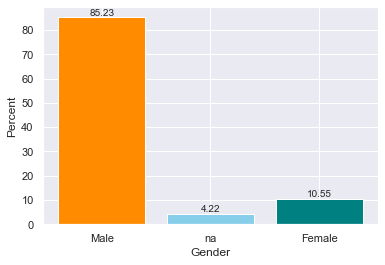

In [18]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.histplot(data = df, x="Gender",stat="percent",multiple ="dodge",shrink=.8)
ax.bar_label(ax.containers[0], fmt='%.2f')
ax.patches[0].set_facecolor('darkorange')
ax.patches[1].set_facecolor('skyblue')
ax.patches[2].set_facecolor('teal')

plt.savefig(path+"/Vis/"+"bar_dist_gender", dpi=600, bbox_inches='tight')

plt.show()

In [19]:
print("Number of dropped rows, which cannot be classified to a gender: " + str(len(df[df.Gender =='na'])) + " + " + str(len(df[df.Gender.isna()])))
df[df.Gender =='na'].to_excel(path + "report/NAs.xlsx")
df[df.Gender.isna()].to_excel(path + "report/isna().xlsx")
df = df.dropna(subset=["Gender"])
df = df[df["Gender"]!="na"]
print("DF shape after NAs got dropped: " + str(df.shape))

df.to_pickle(path+"df_gender_cleaned.pkl")

Number of dropped rows, which cannot be classified to a gender: 25368 + 89
DF shape after NAs got dropped: (576078, 13)


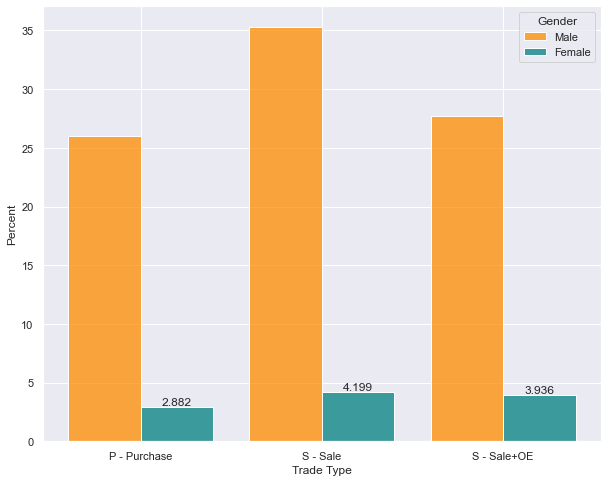

In [20]:
#col=sns.color_palette("pastel")
col=["darkorange","teal"]
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.histplot(data = df, x="Trade Type", hue="Gender", stat="percent",hue_order=["Male", "Female"],multiple ="dodge",shrink=.8,palette=col)
ax.bar_label(ax.containers[0], fmt='%.3f')

plt.savefig(path+"/Vis/"+"bar_dist_dd", dpi=600, bbox_inches='tight')

plt.show()

We will drop all transactions made by a director, that cannot be classified to a gender. This can have different reasons, which will be further explained in the final report. 

In [21]:
df = pd.read_pickle(path +"df_gender_cleaned.pkl")

In [22]:
df.shape

(576078, 13)

Extremely unbalanced dataset, thus we will try out over- and undersampling techniques

1. Undersampling of male transactions

2. Oversampling of female transactions

## Step 3&4: Calculate (Cumulative) Abnormal Returns <a class="anchor" id="step3"></a>


### Import and preprocess daily company and market returns <a class="anchor" id="pp_dr"></a>

In [23]:
if RUN_DAILY_RETURNS == True:
    # first we import the daily returns of the companies
    files = os.listdir(path+"daily/") #8 individual files
    
    daily = pd.DataFrame()
    
    for f in files:
        print(f)
        data = pd.read_excel(path+"daily/"+f,skiprows=5)
        data = data.iloc[1:]
        #transpose isins to row idx
        data = data.transpose()
        #make columns = days 
        data.columns = data.iloc[0]
        data = data.iloc[1:]

        daily = pd.concat([daily,data])
        
    # need to drop this, because company has no daily prices but only value: $$ER: 2381,NO DATA AVAILABLE
    daily = daily.drop('MHY8900D1085') # not in the transactions anyways
    daily.to_pickle(path + "daily.pkl") #daily prices, before calculation of daily return
    DR_companies = daily.pct_change(axis='columns', periods=1)
    DR_companies.replace([np.inf, -np.inf], np.nan, inplace=True)
    DR_companies.to_pickle(path + "DR_companies.pkl")
    
    #Let's also import the daily returns of the market
    daily_market = pd.read_excel(path+"Input/Nasdaq Composite Index (RI (Totlal Return) and PI (Price Index)) 07_1999 - 07_2023.xlsx")
    daily_market.drop([0,1,2,4], inplace=True)
    daily_market = daily_market.transpose()
    daily_market.columns = daily_market.iloc[0]
    daily_market = daily_market.iloc[1:]
    daily_market = daily_market.set_index('Code')

    DR_market = daily_market.pct_change(axis='columns', periods=1)
    DR_market.to_pickle(path + "DR_market.pkl")

else:
    DR_companies = pd.read_pickle(path + "DR_companies.pkl")
    DR_market = pd.read_pickle(path + "DR_market.pkl")

### Calculate Abornal Returns <a class="anchor" id="calcAR"></a>

Let's check if all the ISIN Codes are also found in the daily return company list. 
If we have no daily returns for a company, we cannot calculate the AR and therefore drop those rows/transactions.

In [24]:
df_isins = df["ISIN CODE"].tolist()
dr_isins = DR_companies.index.values.tolist()

isin_not_in_dr = set(df_isins)-set(dr_isins)
print("Number of distinct ISIN Codes not found in daily returns list: " +str((len(isin_not_in_dr))))
pd.DataFrame(isin_not_in_dr).to_excel(path+"report/ISIN_notinDR.xlsx")
df = df[~df['ISIN CODE'].isin(isin_not_in_dr)]
print("\nDf shape after dropping companies, for which we don't have daily returns: " + str(df.shape))


Number of distinct ISIN Codes not found in daily returns list: 121

Df shape after dropping companies, for which we don't have daily returns: (571674, 13)


Some more preprocessing before calculating the individual Abnormal Returns.
For the (C)AR calculations, we need sufficient past daily returns and also a long enough timeframe for the future predictions. 
Thus, we drop all transactions that are too recent (event window too small), as well as all transactions before 01.01.2003. 

In [25]:
print("Number of transactions after January 01 (too recent): " + str(len(df[df['Filing Date'] > "2023-01-01 00:00:00"])))
df[df['Filing Date'] > "2023-01-01 00:00:00"].to_excel(path+"report/FilingDate_toorecent.xlsx")
df = df.drop(df[df['Filing Date'] > "2023-01-01 00:00:00"].index)
print(df.shape)

print("\n"+"Number of transactions before 1.8.2004 (no market RI data before Sept 03): " + str(len(df[df['Filing Date'] < "2004-08-01 00:00:00"])))
df = df.drop(df[df['Filing Date'] < "2004-08-01 00:00:00"].index)
df.to_pickle(path+"df_prepocessed.pkl")
#df = pd.read_pickle(path+"df_prepocessed.pkl")
df.shape

Number of transactions after January 01 (too recent): 21084
(550590, 13)

Number of transactions before 1.8.2004 (no market RI data before Sept 03): 31821


(518769, 13)

In [26]:
DR_companies.replace(np.nan, 0.0, inplace=True)

In [27]:
DR_companies.isna().sum().value_counts()

0    6263
dtype: int64

In [28]:
df.shape

(518769, 13)

In [29]:
RUN_Calc_AR =False
if RUN_Calc_AR == True:
    mr = DR_market[:1]
    cols = [str(item)for item in range(-20,21)]
    start_time = time.time()
    empty_ = pd.DataFrame(np.zeros((1, 41))).astype("float32")
    empty_all = []
    est_window_market = []
    event_window_market= []
    eps=[]
    
    for i in range(1):
        
        scope = np.ceil(df.shape[0]/4).astype("int64")
        print(i)
        start = i*scope
        end = start+scope
        print(start,end)
        
        # cr = company daily return, mr = market daily return
        ARs = pd.DataFrame()
        count = 1 # DQ-check in case of error
        
        for v in df.values[start:2000,:]:

            event_date = v[0]
            isin = v[-2]
            #print(isin)
            cr = DR_companies.loc[isin]
            
            abnormal_returns,est_window_market_idv,event_window_market_idv,eps_idv = calculate_AR.run_calculation_AR(event_date,cr,mr)
            
            check_if_empty = (abnormal_returns == empty_).all()
            if (check_if_empty == True).all():
                empty_all.append(abnormal_returns)
            else:
                est_window_market.append(est_window_market_idv)
                event_window_market.append(event_window_market_idv)
                eps.append(eps_idv)
            ARs = pd.concat([ARs,pd.DataFrame(abnormal_returns)])
            if count == 555:
                test_eps = eps_idv
                test_est = est_window_market_idv
                test_event = event_window_market_idv
                test_ar = abnormal_returns
                test_nr = len(empty_all)
                
            count+=1
            
        ARs.columns = cols
        print(ARs.shape)
        #print(df[start:end].shape)
        df_all = pd.concat([df[start:end].reset_index(drop=True), ARs.reset_index(drop=True)], axis=1)
        print(df_all.shape)

        # preprocessing: drop all empty rows with no AR
        df_subset = df_all.iloc[:, 13:54]
        df_subset['matching'] = df_subset.eq(df_subset.iloc[:,0], axis=0).all(1)
        drop_idx = df_subset[df_subset["matching"]==True].index.tolist()
        print("Number of empty (only 0s) ARs: " + str(len(drop_idx)))
        ARs =  df_all.drop(df_all.index[d] for d in drop_idx)     
        ARs = ARs.reset_index(drop=True)
        #ARs.to_pickle(path +"/ARs/" +f"ARs_{i}.pkl")

        print("--- %s minutes ---" % ((time.time() - start_time)/60))
        break

    with open(path+'est_window_market.pkl', 'wb') as f:
           pickle.dump(est_window_market, f)

    with open(path+'event_window_market.pkl', 'wb') as f:
           pickle.dump(event_window_market, f)

    with open(path+'empty_all.pkl', 'wb') as f:
           pickle.dump(empty_all, f)
            
    with open(path+'eps.pkl', 'wb') as f:
           pickle.dump(eps, f)
            
    ARs = pd.DataFrame()
    for i in range(4):
        part = pd.read_pickle(path+"/ARs/" +f"ARs_{i}.pkl")
        print(part.shape)
        ARs = pd.concat([ARs,part])
    print(ARs.shape)
    ARs = ARs.reset_index(drop=True)
    
else:
    ARs = pd.DataFrame()
    for i in range(4):
        part = pd.read_pickle(path+"/ARs/" +f"ARs_{i}.pkl")
        print(part.shape)
        ARs = pd.concat([ARs,part])
    print(ARs.shape)
    ARs = ARs.reset_index(drop=True)    
    
    est_window_market = pd.read_pickle(path+"est_window_market.pkl")
    event_window_market= pd.read_pickle(path+"event_window_market.pkl")
    empty_all = pd.read_pickle(path+"empty_all.pkl") 
    eps = pd.read_pickle(path+"eps.pkl") 

(122260, 54)
(121330, 54)
(118923, 54)
(119701, 54)
(482214, 54)


In [30]:
ARs.shape

(482214, 54)

In [31]:
ARs.Ticker.nunique()

4841

In [32]:
CARs = ARs.iloc[:, 13:54].cumsum(axis=1)
CARs = pd.concat([ARs.iloc[:,0:13],CARs],axis=1)
CARs.to_pickle(path+"CARs.pkl")

Visualize Average Abnormal Returns

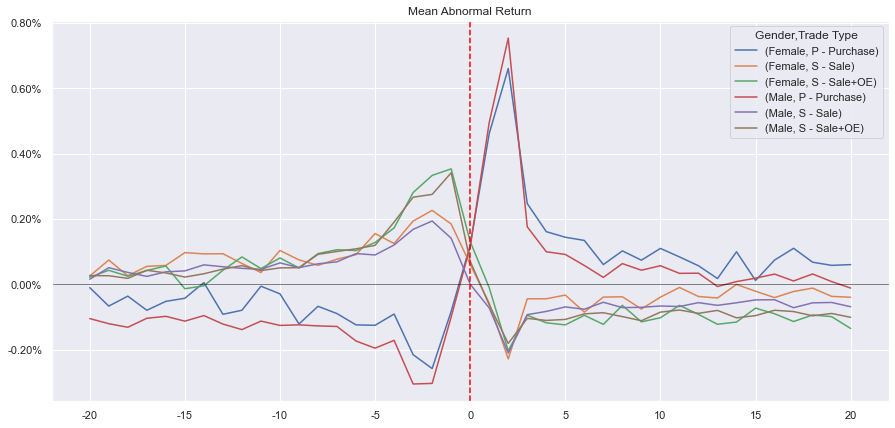

In [33]:
sns.set()
sns.set(style="dark")
sns.set(rc={'figure.figsize':(15,7)})

fig =  ARs.groupby(["Gender","Trade Type"]).mean().transpose().plot()
fig.set_title("Mean Abnormal Return")
vals = fig.get_yticks()
fig.set_yticklabels(['{:,.2%}'.format(x) for x in vals])

plt.axhline(0,color="black",linewidth=0.5)
plt.axvline(x=20,color="red",ls="--")

plt.savefig(path+"/Vis/AAR", dpi=600, bbox_inches='tight')
plt.show()

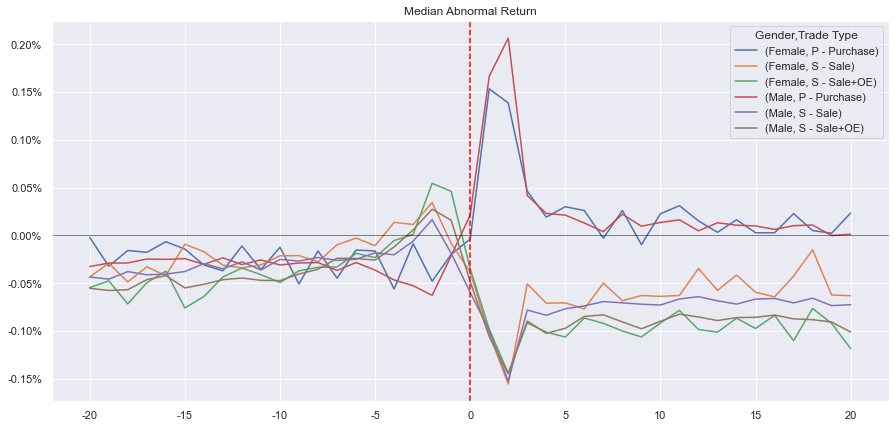

In [34]:
sns.set()
sns.set(style="dark")
sns.set(rc={'figure.figsize':(15,7)})

fig = ARs.groupby(["Gender","Trade Type"]).median().transpose().plot()
fig.set_title("Median Abnormal Return")
vals = fig.get_yticks()
fig.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.axhline(0,color="black",linewidth=0.5)
plt.axvline(x=20,color="red",ls="--")
plt.savefig(path+"/Vis/MAR", dpi=600, bbox_inches='tight')
plt.show()

### Cross Sectional Analysis of descriptive statistics  <a class="anchor" id="edaAR"></a>

In [35]:
groups= ARs.groupby(["Gender","Trade Type"]).size().to_frame(name = 'count').reset_index() 
groups["Share"] = np.round((groups["count"]/ARs.shape[0])*100,2).apply(lambda x: str(x)+"%")
groups

,Gender,Trade Type,count,Share
0,Female,P - Purchase,13379,2.77%
1,Female,S - Sale,19468,4.04%
2,Female,S - Sale+OE,19758,4.1%
3,Male,P - Purchase,118179,24.51%
4,Male,S - Sale,169920,35.24%
5,Male,S - Sale+OE,141510,29.35%


In [36]:
print(groups.to_latex(index=False,formatters={"name": str.upper},float_format="{:.1f}".format))

\begin{tabular}{llrl}
\toprule
Gender &   Trade Type &  count &  Share \\
\midrule
Female & P - Purchase &  13379 &  2.77\% \\
Female &     S - Sale &  19468 &  4.04\% \\
Female &  S - Sale+OE &  19758 &   4.1\% \\
  Male & P - Purchase & 118179 & 24.51\% \\
  Male &     S - Sale & 169920 & 35.24\% \\
  Male &  S - Sale+OE & 141510 & 29.35\% \\
\bottomrule
\end{tabular}



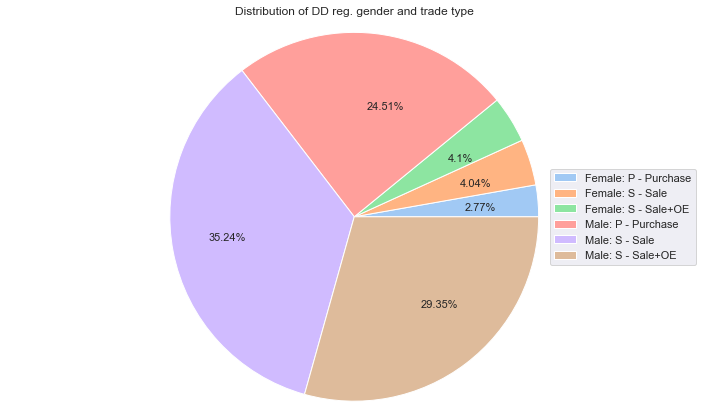

In [37]:
label =groups["Gender"]+": "+groups["Trade Type"]
colors = sns.color_palette('pastel')[0:7]
plt.figure(figsize=(10,6))
#create pie chart
patches, texts =plt.pie(groups["count"],labels=groups["Share"], labeldistance = 0.6,colors = colors)
plt.title("Distribution of DD reg. gender and trade type")
plt.legend(patches, label, loc="center right")
plt.savefig(path+"/Vis/Pie_dist_Groups", dpi=600, bbox_inches='tight')

plt.axis('equal')
plt.tight_layout()
plt.show()


In [38]:
ARs.shape

(482214, 54)

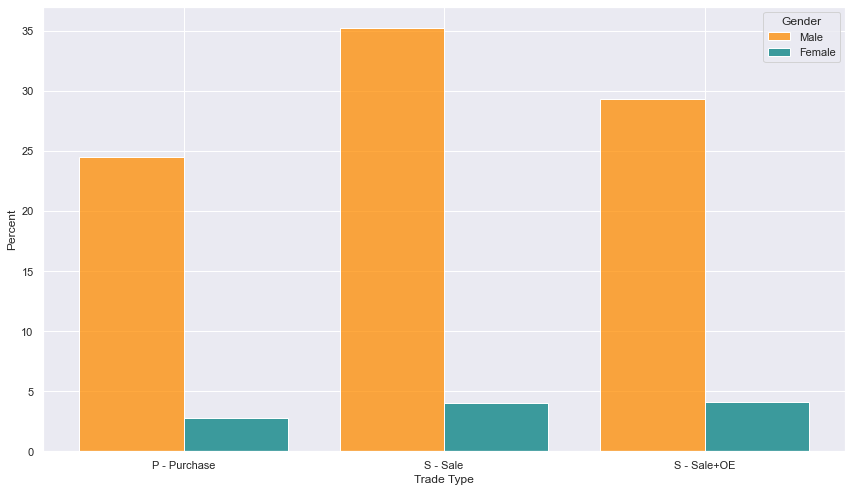

In [39]:
sns.set()
sns.set(style="dark")
sns.set(rc={'figure.figsize':(12,7)})
col=["darkorange","teal"]
sns.histplot(data = ARs, x="Trade Type", hue="Gender", stat="percent",multiple ="dodge",shrink=.8,palette=col)

plt.savefig(path+"/Vis/bar_Groups", dpi=600, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [40]:
fem = ARs[ARs["Gender"]=="Female"]
male = ARs[ARs["Gender"]=="Male"]

In [41]:
shares = pd.DataFrame()
shares["Female"] = fem.groupby(["Trade Type"]).size().transform(lambda x: round(x/sum(x),4)*100)
shares["Male"] = male.groupby(["Trade Type"]).size().transform(lambda x: round(x/sum(x),4)*100)
shares
print(shares.to_latex(formatters={"name": str.upper},float_format="{:.4f}".format))

\begin{tabular}{lrr}
\toprule
{} &  Female &    Male \\
Trade Type   &         &         \\
\midrule
P - Purchase & 25.4300 & 27.5100 \\
S - Sale     & 37.0100 & 39.5500 \\
S - Sale+OE  & 37.5600 & 32.9400 \\
\bottomrule
\end{tabular}



In [42]:
#ARs.groupby(["Gender","Trade Type"]).size().to_frame(name = 'count').reset_index() 

CAAR = CARs.groupby(["Gender","Trade Type"]).mean().transpose()
MCAR = CARs.groupby(["Gender","Trade Type"]).median().transpose()

print(CAAR.describe().to_latex(index=False,formatters={"name": str.upper},float_format="{:.4f}".format))

\begin{tabular}{rrrrrr}
\toprule
      Female & \multicolumn{3}{l}{Male} \\
P - Purchase & S - Sale & S - Sale+OE & P - Purchase & S - Sale & S - Sale+OE \\
\midrule
     41.0000 &  41.0000 &     41.0000 &      41.0000 &  41.0000 &     41.0000 \\
     -0.0010 &   0.0107 &      0.0087 &      -0.0122 &   0.0059 &      0.0079 \\
      0.0081 &   0.0053 &      0.0066 &       0.0070 &   0.0043 &      0.0060 \\
     -0.0167 &   0.0003 &      0.0002 &      -0.0290 &  -0.0000 &      0.0003 \\
     -0.0061 &   0.0072 &      0.0029 &      -0.0152 &   0.0025 &      0.0026 \\
     -0.0018 &   0.0117 &      0.0072 &      -0.0103 &   0.0052 &      0.0064 \\
      0.0060 &   0.0143 &      0.0135 &      -0.0080 &   0.0086 &      0.0126 \\
      0.0124 &   0.0197 &      0.0217 &      -0.0011 &   0.0146 &      0.0201 \\
\bottomrule
\end{tabular}



Visualize descriptive stats

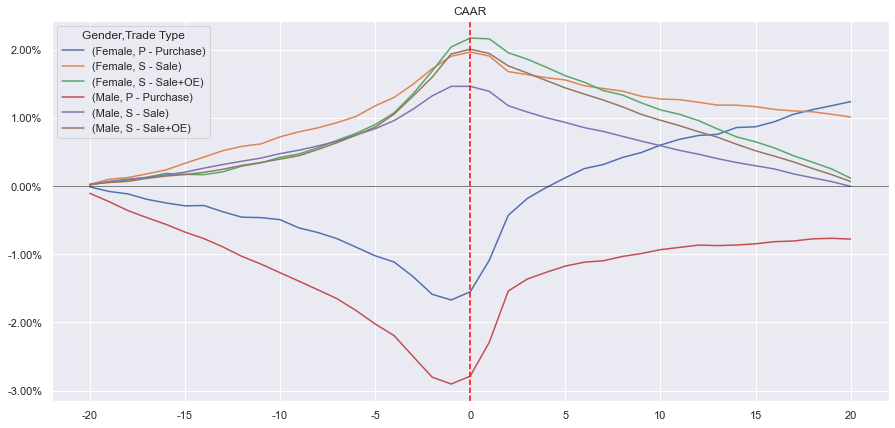

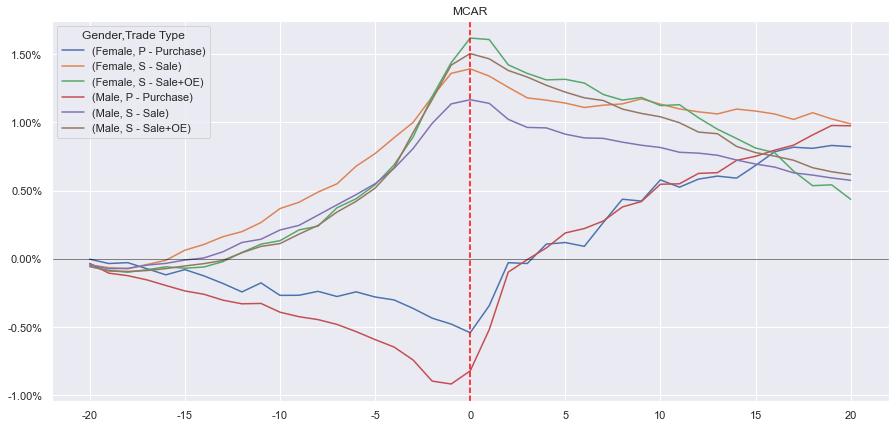

In [43]:
sns.set()
sns.set(style="dark")
sns.set(rc={'figure.figsize':(15,7)})

CAAR['Day'] = CAAR.index
fig = CAAR.plot()
fig.set_title("CAAR")
vals = fig.get_yticks()
fig.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.axhline(0,color="black",linewidth=0.5)
plt.axvline(x=20,color="red",ls="--")
plt.savefig(path+"/Vis/CAAR", dpi=600, bbox_inches='tight')
plt.show()

MCAR['Day'] = MCAR.index
fig = MCAR.plot()
fig.set_title("MCAR")
vals = fig.get_yticks()
fig.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.axhline(0,color="black",linewidth=0.5)
plt.axvline(x=20,color="red",ls="--")
plt.savefig(path+"/Vis/MCAR", dpi=600, bbox_inches='tight')
plt.show()

101.0
104.62443046213929


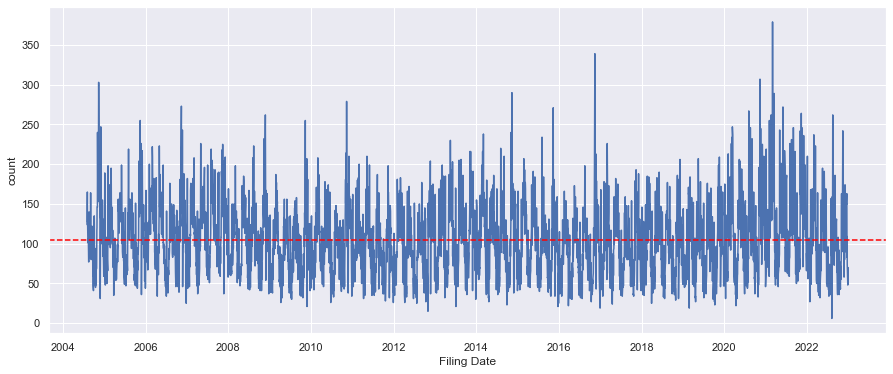

In [44]:
dates_cluster = ARs.groupby(["Filing Date"]).size().to_frame(name = 'count').reset_index() 
print(dates_cluster["count"].median())
print(dates_cluster["count"].mean())

plt.figure(figsize=(15,6))
sns.lineplot(data=dates_cluster, x="Filing Date", y="count")
plt.axhline(y=dates_cluster["count"].mean(),color="red",ls="--")

plt.savefig(path+"/Vis/dates_cluster", dpi=600, bbox_inches='tight')

In [45]:
top10_dates = dates_cluster.sort_values(by="count", ascending=False)[:10]
print(top10_dates.to_latex(index=False,formatters={"name": str.upper},float_format="{:.1f}".format))

\begin{tabular}{lr}
\toprule
Filing Date &  count \\
\midrule
 2021-03-03 &    379 \\
 2016-11-14 &    339 \\
 2020-11-12 &    307 \\
 2004-11-12 &    303 \\
 2014-11-12 &    290 \\
 2021-03-17 &    289 \\
 2010-11-12 &    279 \\
 2006-11-13 &    273 \\
 2021-06-03 &    272 \\
 2015-11-12 &    271 \\
\bottomrule
\end{tabular}



### Let's analyze the different time frames

In [46]:
RUN_stats = False
if RUN_stats == True:
    stats = pd.DataFrame()
    timeframes = [("-20","0"),("0","5"),("0","10"),("0","20")]
    row,col = 0,0

    fig, axs = plt.subplots(ncols=2,nrows=2)
    plt.figsize=(10,10)

    for tf in timeframes:
        timeframe = CAAR.loc[tf[0]:tf[1]]

        fig = timeframe.plot(ax=axs[col][row])
        fig.set_title("Timeframe: "+str(tf))
        fig.axhline(0,color="black",linewidth=0.5)

        fig.legend(fontsize="7" ,loc="upper left")
        fig.set(ylim=(-0.015,0.035))
        if (row == 0) & (col==0):
            row=1
            fig.axvline(x=20,color="red",ls="--") 
        elif (row == 0) & (col==1):
            row=1
            col=1
            fig.axvline(x=0,color="red",ls="--")
        elif (row == 1) & (col==0):
            row=0
            col=1 
            fig.axvline(x=0,color="red",ls="--")
        if (row == 1) & (col==1):
            fig.axvline(x=0,color="red",ls="--")    
        #let's collect the stats for each timeframe
        descr_stats =CAAR.describe().transpose()
        descr_stats["timeframe"]=str(tf)
        stats = pd.concat([stats,descr_stats])

    plt.savefig(path+"/Vis/tfs", dpi=600, bbox_inches='tight')
    plt.show()    

In [47]:
#stats

## Step 5: Statistical Hypothesis Testing  <a class="anchor" id="sttest"></a>

### Gender Study   <a class="anchor" id="descr"></a>

In [48]:
RUN_statistics = False
if RUN_statistics == True: 
    
    CAR_periods=[[0, 19], [20, 40],[20, 25],[20, 21]]
    print_period = ["[-20,-1]", "[0,20]","[0,5]","[0,1]"]
    Genders = ["Male","Female"]
    Transaction_type = ["P - Purchase", "S - Sale", "S - Sale+OE"]

    test_results = []
    test_index = []

    for gen in Genders:
        for type_ in Transaction_type:
            count=0
            for CAR_period in CAR_periods:

                print(gen)
                print(type_)
                print(CAR_period)
                print(print_period[count])
                df = ARs[(ARs['Gender'] == gen) & (ARs['Trade Type'] == type_)].iloc[:,13:54]
                idx_list = list(df.index.values)

                AR = np.asarray(df.values)
                eps_ = np.asarray(np.squeeze([eps[idx] for idx in idx_list]))
                event_window_market_ = np.asarray(np.squeeze([event_window_market[idx] for idx in idx_list]))
                est_window_market_ = np.asarray(np.squeeze([est_window_market[idx] for idx in idx_list]))

                grank_result = grank(AR, eps_, est_window_market_, event_window_market_, CAR_period, False)
                adj_grank_result = grank(AR, eps_, est_window_market_, event_window_market_, CAR_period, True)
                adjBMP_result = adjBMP(AR, eps_, est_window_market_, event_window_market_, CAR_period)

                CAAR = AR[:,CAR_period[0]:(CAR_period[1]+1)].sum(axis=1).mean() # scalar value
                test_results.append((CAAR, grank_result.pvalue, grank_result.statistic, adjBMP_result.pvalue, adjBMP_result.statistic))
                test_index.append((gen, type_, str(print_period[count])))
                count+=1
                
    test_results_df = pd.DataFrame(test_results)
    test_results_df.columns = ["CAAR", "GRANK p-value", "GRANK t-statistic", "adjBMP p-value", "adjBMP t-statistic"]
    test_results_df.index =pd.MultiIndex.from_tuples(test_index, names=("Gender", "Trade Type", "CAR Period"))
    test_results_df.to_pickle(path+"test_results.pkl")
else: 
    test_results_df = pd.read_pickle(path+'test_results.pkl')

In [49]:
#test_results_df.round(5)

Create tables for latex report

In [50]:
purchase = test_results_df[np.in1d(test_results_df.index.get_level_values(1), ['P - Purchase'])][['CAAR', 'GRANK p-value', 'GRANK t-statistic', 'adjBMP p-value', 'adjBMP t-statistic']]
sales = test_results_df[np.in1d(test_results_df.index.get_level_values(1), ['S - Sale'])][['CAAR', 'GRANK p-value', 'GRANK t-statistic', 'adjBMP p-value', 'adjBMP t-statistic']]
SOE = test_results_df[np.in1d(test_results_df.index.get_level_values(1), ['S - Sale+OE'])][['CAAR', 'GRANK p-value', 'GRANK t-statistic', 'adjBMP p-value', 'adjBMP t-statistic']]

In [51]:
print(purchase.droplevel('Trade Type').to_latex(index=True,formatters={"name": str.upper},float_format="{:.4f}".format))
print(sales.droplevel('Trade Type').to_latex(index=True,formatters={"name": str.upper},float_format="{:.4f}".format))
print(SOE.droplevel('Trade Type').to_latex(index=True,formatters={"name": str.upper},float_format="{:.4f}".format))

\begin{tabular}{llrrrrr}
\toprule
       &       &    CAAR &  GRANK p-value &  GRANK t-statistic &  adjBMP p-value &  adjBMP t-statistic \\
Gender & CAR Period &         &                &                    &                 &                     \\
\midrule
Male & [-20,-1] & -0.0290 &         0.0000 &            -7.8689 &          0.0000 &            -18.5290 \\
       & [0,20] &  0.0212 &         0.0000 &            23.7332 &          0.0000 &             71.8555 \\
       & [0,5] &  0.0173 &         0.0000 &            22.6347 &          0.0000 &             44.4483 \\
       & [0,1] &  0.0061 &         0.0000 &            12.7118 &          0.0000 &             19.4556 \\
Female & [-20,-1] & -0.0167 &         0.0001 &            -3.9222 &          0.0000 &            -13.1806 \\
       & [0,20] &  0.0291 &         0.0000 &            13.7785 &          0.0000 &             18.9293 \\
       & [0,5] &  0.0179 &         0.0000 &            12.4261 &          0.0000 &             16.

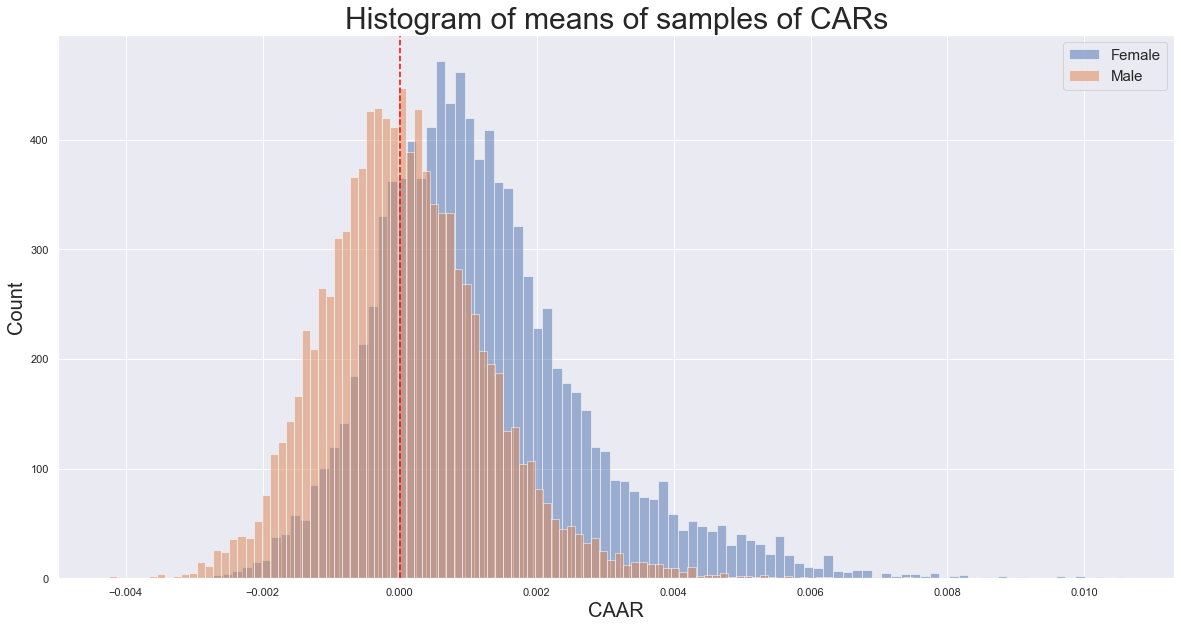

In [52]:
#Recommendation Prof. Aussenegg: Simulate CAAR mean differences
RUN_statistics = True
if RUN_statistics == True:

    np.random.seed(42)

    CAR_periods=[[0, 19], [20, 40],[20, 25],[20, 21]]
    print_period = ["[-20,-1]", "[0,20]","[0,5]","[0,1]"]
    Transaction_type = ["P - Purchase", "S - Sale", "S - Sale+OE"]
         
    ttest_results = []
    ttest_index = []
    
    for type_ in Transaction_type:  
        count=0
        for cp in CAR_periods:

            print(type_)
            print(cp)

            AR_fem = ARs[(ARs['Gender'] == "Female") & (ARs['Trade Type'] == type_)].iloc[:,13:54].values
            sample_CAR_female = AR_fem[:,cp[0]:(cp[1]+1)].sum(axis=1)

            AR_male = ARs[(ARs['Gender'] == "Male") & (ARs['Trade Type'] == type_)].iloc[:,13:54].values
            sample_CAR_male= AR_male[:,cp[0]:(cp[1]+1)].sum(axis=1)

            CAAR_fem = sample_CAR_female.mean()
            CAAR_male = sample_CAR_male.mean()
            CAAR_diff = CAAR_male-CAAR_fem

            sample_size = 1500
            diffs = []
            subsample_means_CAR_female = []
            subsample_means_CAR_male = []
            for i in range(10000):
                # pick subsample
                subsample_female = np.random.choice(sample_CAR_female, sample_size, replace=True)
                subsample_male = np.random.choice(sample_CAR_male, sample_size, replace=True)
                diff = subsample_male-subsample_female
                subsample_means_CAR_female.append(subsample_female.mean())
                subsample_means_CAR_male.append(subsample_male.mean())
                diffs.append(diff.mean())

            fig = plt.figure(figsize=(20, 10))
            plt.hist(subsample_means_CAR_female,bins = 100, alpha = 0.5)
            plt.hist(subsample_means_CAR_male,bins = 100, alpha = 0.5)
            plt.legend(["Female", "Male"], fontsize = 15)
            plt.axvline(x=0.0,color="red",ls="--")
            plt.xlabel("CAAR", fontsize=20)
            plt.ylabel("Count", fontsize=20)

            plt.title("Histogram of means of samples of CARs", fontsize=30)

            plt.savefig(path+"Vis/"+"histo_"+str(cp)+"_"+str(type_)+".png", dpi=600, bbox_inches='tight')

            clear_output(wait=True)
            plt.show()

            sign = int(2*(bool(CAAR_diff<0) -0.5)) #  check for the correct side of 0.
            p_value = 2*np.mean(sign*np.asarray(diffs) > 0) #  times 2 to take into account we are looking at the interesting side always

            ttest_results.append((CAAR_diff, p_value))
            ttest_index.append((type_, str(print_period[count])))
            count+=1
            
        ttest_CAR_df = pd.DataFrame(ttest_results)
        ttest_CAR_df.columns = ["Δ CAAR", "p-value"]
        ttest_CAR_df.index =pd.MultiIndex.from_tuples(ttest_index, names=("Trade Type", "CAR Period"))
        ttest_CAR_df.to_pickle(path+"ttest_CAR.pkl")  
else: 
    ttest_CAR_df = pd.read_pickle(path+'ttest_CAR.pkl')
    #print(ttest_CAR_df.to_latex(index=True,formatters={"name": str.upper},float_format="{:.4f}".format))

In [53]:
print(ttest_CAR_df.to_latex(index=True,formatters={"name": str.upper},float_format="{:.4f}".format))

\begin{tabular}{llrr}
\toprule
            &       &  Δ CAAR &  p-value \\
Trade Type & CAR Period &         &          \\
\midrule
P - Purchase & [-20,-1] & -0.0123 &   0.8788 \\
            & [0,20] & -0.0078 &   1.4448 \\
            & [0,5] & -0.0006 &   1.4478 \\
            & [0,1] &  0.0003 &   0.6212 \\
S - Sale & [-20,-1] & -0.0044 &   0.6598 \\
            & [0,20] & -0.0057 &   0.4640 \\
            & [0,5] & -0.0018 &   0.6142 \\
            & [0,1] & -0.0008 &   0.6972 \\
S - Sale+OE & [-20,-1] & -0.0010 &   0.8560 \\
            & [0,20] &  0.0005 &   0.9214 \\
            & [0,5] & -0.0008 &   0.7770 \\
            & [0,1] & -0.0011 &   0.5712 \\
\bottomrule
\end{tabular}



### Analyze titles  <a class="anchor" id="titles"></a>

As discussed with Prof. Aussenegg, all titles where female count > 1000 will be used for analysis  
Male:   
(6) Dir, 10%       9487  
(8) SVP            6194  
Group Member, 10%                  1928 dropped, bcs only 9 sales (female) and 25 (male).  

In [54]:
CARs.shape

(482214, 54)

In [55]:
ARs.shape

(482214, 54)

In [56]:
CARs.Title.nunique()

16333

In [57]:
CARs[CARs["Gender"]=="Female"].Title.value_counts()[0:20]

Dir                               13983
10%                                2409
Group Member, 10%                  1928
CFO                                1838
Pres, CEO                          1161
SVP                                1085
EVP                                1040
CEO                                1012
EVP, CFO                            650
Dir, 10%                            630
GC                                  606
COO                                 586
See Remarks                         525
EVP, GC                             465
VP                                  465
CMO                                 465
Chief Accounting Officer            409
Member of 10% owner group, 10%      404
SVP, GC                             382
Pres                                369
Name: Title, dtype: int64

In [58]:
top_titles = CARs[CARs["Gender"]=="Female"].Title.value_counts(normalize=True)[0:8].to_frame(name = 'Female')
top8_titles = top_titles.index.to_list()
top8_titles.remove("Group Member, 10%")

top_titles

,Female
Dir,0.265811
10%,0.045794
"Group Member, 10%",0.036651
CFO,0.034940
"Pres, CEO",0.022070
SVP,0.020625
EVP,0.019770
CEO,0.019238


In [59]:
#absolute Zahlen
titles = ARs[ARs["Title"].isin(top8_titles)]
table_titles = titles[titles["Gender"]=="Female"].groupby(["Title","Trade Type"]).size().to_frame(name="Female")
table_titles["Male"] =titles[titles["Gender"]=="Male"].groupby(["Title","Trade Type"]).size()
table_titles
    
print(table_titles.round(2).to_latex())

\begin{tabular}{llrr}
\toprule
    &             &  Female &   Male \\
Title & Trade Type &         &        \\
\midrule
10\% & P - Purchase &     783 &  10086 \\
    & S - Sale &    1382 &  10760 \\
    & S - Sale+OE &     244 &    744 \\
CEO & P - Purchase &     148 &   3422 \\
    & S - Sale &     350 &   5518 \\
    & S - Sale+OE &     514 &   5863 \\
CFO & P - Purchase &     367 &   2878 \\
    & S - Sale &     719 &   5313 \\
    & S - Sale+OE &     752 &   5455 \\
Dir & P - Purchase &    6046 &  52265 \\
    & S - Sale &    4632 &  43269 \\
    & S - Sale+OE &    3305 &  26891 \\
EVP & P - Purchase &     171 &   1854 \\
    & S - Sale &     397 &   2969 \\
    & S - Sale+OE &     472 &   3576 \\
Pres, CEO & P - Purchase &     237 &   6120 \\
    & S - Sale &     396 &   7415 \\
    & S - Sale+OE &     528 &   7469 \\
SVP & P - Purchase &     370 &    839 \\
    & S - Sale &     280 &   2304 \\
    & S - Sale+OE &     435 &   3051 \\
\bottomrule
\end{tabular}



In [75]:
#relative frequences 
titles = ARs[ARs["Title"].isin(top8_titles)]
table_titles = titles[titles["Gender"]=="Female"].groupby(["Title","Trade Type"]).size().transform(lambda x: round(x/sum(x),4)*100).to_frame(name="Female")
table_titles["Male"] =titles[titles["Gender"]=="Male"].groupby(["Title","Trade Type"]).size().transform(lambda x: round(x/sum(x),4)*100)
    
print(table_titles.round(2).to_latex())

\begin{tabular}{llrr}
\toprule
    &             &  Female &   Male \\
Title & Trade Type &         &        \\
\midrule
10\% & P - Purchase &    3.48 &   4.85 \\
    & S - Sale &    6.13 &   5.17 \\
    & S - Sale+OE &    1.08 &   0.36 \\
CEO & P - Purchase &    0.66 &   1.64 \\
    & S - Sale &    1.55 &   2.65 \\
    & S - Sale+OE &    2.28 &   2.82 \\
CFO & P - Purchase &    1.63 &   1.38 \\
    & S - Sale &    3.19 &   2.55 \\
    & S - Sale+OE &    3.34 &   2.62 \\
Dir & P - Purchase &   26.84 &  25.12 \\
    & S - Sale &   20.56 &  20.80 \\
    & S - Sale+OE &   14.67 &  12.92 \\
EVP & P - Purchase &    0.76 &   0.89 \\
    & S - Sale &    1.76 &   1.43 \\
    & S - Sale+OE &    2.10 &   1.72 \\
Pres, CEO & P - Purchase &    1.05 &   2.94 \\
    & S - Sale &    1.76 &   3.56 \\
    & S - Sale+OE &    2.34 &   3.59 \\
SVP & P - Purchase &    1.64 &   0.40 \\
    & S - Sale &    1.24 &   1.11 \\
    & S - Sale+OE &    1.93 &   1.47 \\
\bottomrule
\end{tabular}



Problem: even though titles count is >1000 in total, if we break it down to P/S/SOE, we end up with very few transactions per subgroup. 

let's test CAAR differences and significance. Problem: 84 values. Too many to analyze. 2 (gender) * 8 (titles) * 3 (transactions types) * 4 (time frames)  
After discussion with Prof. Aussenegg, we will analyze the total timeframe after announcement ([0,20]) and the CAAR difference of the first day [0,1]

In [61]:
RUN_statistics = False
if RUN_statistics == True: 
    
    CAR_periods=[[20,21], [20, 40]]
    print_period = ["[0,1]", "[0,20]"]
    Genders = ["Male","Female"]
    Transaction_type = ["P - Purchase", "S - Sale", "S - Sale+OE"]
    
    titles_results = []
    titles_index = []

    for gen in Genders:
        for title in top8_titles:
            for type_ in Transaction_type:
                count=0
                for CAR_period in CAR_periods:

                    df = ARs[(ARs['Gender'] == gen) & (ARs['Trade Type'] == type_) & (ARs['Title'] == title)].iloc[:,13:54]
                    idx_list = list(df.index.values)

                    AR = np.asarray(df.values)

                    CAAR = AR[:,CAR_period[0]:(CAR_period[1]+1)].sum(axis=1).mean() # scalar value
                    titles_results.append(CAAR)
                    titles_index.append((gen, title, type_, str(print_period[count])))
                    count+=1

        titles_results_df = pd.DataFrame(titles_results)
        titles_results_df.columns = ["CAAR"]
        titles_results_df.index =pd.MultiIndex.from_tuples(titles_index, names=("Gender", "Title","Trade Type", "CAR Period"))
        titles_results_df.to_pickle(path+"titles_results.pkl")
else: 
    titles_results_df = pd.read_pickle(path+'titles_results.pkl')

In [62]:
#print(titles_results_df.to_latex(index=True,formatters={"name": str.upper},float_format="{:.4f}".format))

Let's visualize CAR and CAAR

In [63]:
titles_results_df

CAAR
Gender Title Trade Type   CAR Period          
Male   Dir   P - Purchase [0,1]       0.004546
                          [0,20]      0.007835
             S - Sale     [0,1]      -0.000370
                          [0,20]     -0.013878
             S - Sale+OE  [0,1]      -0.000605
...                                        ...
Female CEO   P - Purchase [0,20]      0.055604
             S - Sale     [0,1]       0.003361
                          [0,20]     -0.007814
             S - Sale+OE  [0,1]       0.001618
                          [0,20]     -0.010106

[84 rows x 1 columns]

In [64]:
sub = titles_results_df.loc[("Male",slice(None),"P - Purchase", '[0,20]'), :]
male_P_min = sub.idxmax()
print("Male Purchase: " + str(titles_results_df.loc[male_P_min]))

sub = titles_results_df.loc[("Female",slice(None),"P - Purchase", '[0,20]'), :]
female_P_min = sub.idxmax()
print("Female Purchase: " + str(titles_results_df.loc[female_P_min]))

sub = titles_results_df.loc[("Male",slice(None),"S - Sale", '[0,20]'), :]
male_S_max = sub.idxmin()
print("Male Sale: " + str(titles_results_df.loc[male_S_max]))

sub = titles_results_df.loc[("Female",slice(None),"S - Sale", '[0,20]'), :]
female_S_max = sub.idxmin()
print("Female Sale: " + str(titles_results_df.loc[female_S_max]))

sub = titles_results_df.loc[("Male",slice(None),"S - Sale+OE", '[0,20]'), :]
male_SOE_max = sub.idxmin()
print("Male S+OE: " + str(titles_results_df.loc[male_SOE_max]))

sub = titles_results_df.loc[("Female",slice(None),"S - Sale+OE", '[0,20]'), :]
female_SOE_max = sub.idxmin()
print("Female S+OE: " + str(titles_results_df.loc[female_SOE_max]))

Male Purchase:                                           CAAR
Gender Title Trade Type   CAR Period          
Male   CEO   P - Purchase [0,20]      0.055573
Female Purchase:                                           CAAR
Gender Title Trade Type   CAR Period          
Female CEO   P - Purchase [0,20]      0.055604
Male Sale:                                            CAAR
Gender Title     Trade Type CAR Period         
Male   Pres, CEO S - Sale   [0,20]     -0.02128
Female Sale:                                         CAAR
Gender Title Trade Type CAR Period          
Female SVP   S - Sale   [0,20]     -0.016898
Male S+OE:                                          CAAR
Gender Title Trade Type  CAR Period          
Male   CFO   S - Sale+OE [0,20]     -0.023141
Female S+OE:                                              CAAR
Gender Title     Trade Type  CAR Period          
Female Pres, CEO S - Sale+OE [0,20]     -0.038451


In [65]:
sub = titles_results_df.loc[("Male",slice(None),"P - Purchase", '[0,1]'), :]
male_P_min = sub.idxmax()
print("Male Purchase: " + str(titles_results_df.loc[male_P_min]))

sub = titles_results_df.loc[("Female",slice(None),"P - Purchase", '[0,1]'), :]
female_P_min = sub.idxmax()
print("Female Purchase: " + str(titles_results_df.loc[female_P_min]))

sub = titles_results_df.loc[("Male",slice(None),"S - Sale", '[0,1]'), :]
male_S_max = sub.idxmin()
print("Male Sale: " + str(titles_results_df.loc[male_S_max]))

sub = titles_results_df.loc[("Female",slice(None),"S - Sale", '[0,1]'), :]
female_S_max = sub.idxmin()
print("Female Sale: " + str(titles_results_df.loc[female_S_max]))

sub = titles_results_df.loc[("Male",slice(None),"S - Sale+OE", '[0,1]'), :]
male_SOE_max = sub.idxmin()
print("Male S+OE: " + str(titles_results_df.loc[male_SOE_max]))

sub = titles_results_df.loc[("Female",slice(None),"S - Sale+OE", '[0,1]'), :]
female_SOE_max = sub.idxmin()
print("Female S+OE: " + str(titles_results_df.loc[female_SOE_max]))

Male Purchase:                                           CAAR
Gender Title Trade Type   CAR Period          
Male   CEO   P - Purchase [0,1]       0.012132
Female Purchase:                                           CAAR
Gender Title Trade Type   CAR Period          
Female CEO   P - Purchase [0,1]       0.016121
Male Sale:                                         CAAR
Gender Title Trade Type CAR Period          
Male   10%   S - Sale   [0,1]      -0.005646
Female Sale:                                         CAAR
Gender Title Trade Type CAR Period          
Female 10%   S - Sale   [0,1]      -0.004297
Male S+OE:                                          CAAR
Gender Title Trade Type  CAR Period          
Male   10%   S - Sale+OE [0,1]      -0.002443
Female S+OE:                                             CAAR
Gender Title     Trade Type  CAR Period         
Female Pres, CEO S - Sale+OE [0,1]      -0.00396


In [66]:
titles_results_df.loc[("Male",slice(None),"S - Sale+OE", '[0,1]'), :]

CAAR
Gender Title     Trade Type  CAR Period          
Male   Dir       S - Sale+OE [0,1]      -0.000605
       10%       S - Sale+OE [0,1]      -0.002443
       CFO       S - Sale+OE [0,1]       0.000954
       Pres, CEO S - Sale+OE [0,1]      -0.000225
       SVP       S - Sale+OE [0,1]       0.000198
       EVP       S - Sale+OE [0,1]      -0.000295
       CEO       S - Sale+OE [0,1]      -0.000215

In [ ]:
RUN_statistics = False
if RUN_statistics == True: 
    
    CAR_periods=[[20,21], [20, 40]]
    print_period = ["[0,1]", "[0,20]"]
    Genders = ["Male","Female"]
    
    P_CEO_results = []
    titles_index = []

    for gen in Genders:
        count=0
        for CAR_period in CAR_periods:
            
            df = ARs[(ARs['Gender'] == gen) & (ARs['Trade Type'] == "P - Purchase") & (ARs['Title'] == "CEO")].iloc[:,13:54]
            idx_list = list(df.index.values)

            AR = np.asarray(df.values)
            eps_ = np.asarray(np.squeeze([eps[idx] for idx in idx_list]))
            event_window_market_ = np.asarray(np.squeeze([event_window_market[idx] for idx in idx_list]))
            est_window_market_ = np.asarray(np.squeeze([est_window_market[idx] for idx in idx_list]))

            grank_result = grank(AR, eps_, est_window_market_, event_window_market_, CAR_period, False)
            adj_grank_result = grank(AR, eps_, est_window_market_, event_window_market_, CAR_period, True)
            adjBMP_result = adjBMP(AR, eps_, est_window_market_, event_window_market_, CAR_period)

            CAAR = AR[:,CAR_period[0]:(CAR_period[1]+1)].sum(axis=1).mean() # scalar value
            P_CEO_results.append((CAAR, grank_result.pvalue, grank_result.statistic, adjBMP_result.pvalue, adjBMP_result.statistic))
            titles_index.append((gen, title, "P - Purchase", str(print_period[count])))
            count+=1

    P_CEO_results_df = pd.DataFrame(P_CEO_results)
    P_CEO_results_df.columns = ["CAAR", "GRANK p-value", "GRANK t-statistic", "adjBMP p-value", "adjBMP t-statistic"]
    P_CEO_results_df.index =pd.MultiIndex.from_tuples(titles_index, names=("Gender", "Title","Trade Type", "CAR Period"))
    P_CEO_results_df.to_pickle(path+"P_CEO_results_df.pkl")
else: 
    P_CEO_results_df = pd.read_pickle(path+'P_CEO_results_df.pkl')

In [67]:
RUN_statistics = False
if RUN_statistics == True: 
    
    CAR_periods=[[20,21], [20, 40]]
    print_period = ["[0,1]", "[0,20]"]
    Genders = ["Male","Female"]
    
    P_CEO_results = []
    titles_index = []

    for gen in Genders:
        count=0
        for CAR_period in CAR_periods:
            
            df = ARs[(ARs['Gender'] == gen) & (ARs['Trade Type'] == "P - Purchase") & (ARs['Title'] == "CEO")].iloc[:,13:54]
            idx_list = list(df.index.values)

            AR = np.asarray(df.values)
            eps_ = np.asarray(np.squeeze([eps[idx] for idx in idx_list]))
            event_window_market_ = np.asarray(np.squeeze([event_window_market[idx] for idx in idx_list]))
            est_window_market_ = np.asarray(np.squeeze([est_window_market[idx] for idx in idx_list]))

            grank_result = grank(AR, eps_, est_window_market_, event_window_market_, CAR_period, False)
            adj_grank_result = grank(AR, eps_, est_window_market_, event_window_market_, CAR_period, True)
            adjBMP_result = adjBMP(AR, eps_, est_window_market_, event_window_market_, CAR_period)

            CAAR = AR[:,CAR_period[0]:(CAR_period[1]+1)].sum(axis=1).mean() # scalar value
            P_CEO_results.append((CAAR, grank_result.pvalue, grank_result.statistic, adjBMP_result.pvalue, adjBMP_result.statistic))
            titles_index.append((gen, title, "P - Purchase", str(print_period[count])))
            count+=1

    P_CEO_results_df = pd.DataFrame(P_CEO_results)
    P_CEO_results_df.columns = ["CAAR", "GRANK p-value", "GRANK t-statistic", "adjBMP p-value", "adjBMP t-statistic"]
    P_CEO_results_df.index =pd.MultiIndex.from_tuples(titles_index, names=("Gender", "Title","Trade Type", "CAR Period"))
    P_CEO_results_df.to_pickle(path+"P_CEO_results_df.pkl")
else: 
    P_CEO_results_df = pd.read_pickle(path+'P_CEO_results_df.pkl')

In [68]:
P_CEO_results_df
print(P_CEO_results_df.to_latex(index=True,formatters={"name": str.upper},float_format="{:.4f}".format))

\begin{tabular}{llllrrrrr}
\toprule
       &     &              &        &   CAAR &  GRANK p-value &  GRANK t-statistic &  adjBMP p-value &  adjBMP t-statistic \\
Gender & Title & Trade Type & CAR Period &        &                &                    &                 &                     \\
\midrule
Male & CEO & P - Purchase & [0,1] & 0.0121 &         0.0000 &             9.5978 &          0.0000 &              8.0007 \\
       &     &              & [0,20] & 0.0556 &         0.0000 &            16.5004 &          0.0000 &             14.0263 \\
Female & CEO & P - Purchase & [0,1] & 0.0161 &         0.0001 &             3.9529 &          0.0066 &              2.7147 \\
       &     &              & [0,20] & 0.0556 &         0.0000 &             4.6816 &          0.0001 &              3.8236 \\
\bottomrule
\end{tabular}



In [69]:
#Recommendation Prof. Aussenegg: Simulate CAAR mean differences
RUN_statistics = False
if RUN_statistics == True:

    np.random.seed(42)

    CAR_periods=[[0, 19], [20, 40],[20, 25],[20, 21]]
    print_period = ["[-20,-1]", "[0,20]","[0,5]","[0,1]"]
         
    P_CEO_ttest_results = []
    ttest_index = []
    count =0
    for cp in CAR_periods:

        AR_fem = ARs[(ARs['Gender'] == "Female") & (ARs['Trade Type'] == "P - Purchase")& (ARs['Title'] == "CEO")].iloc[:,13:54].values
        sample_CAR_female = AR_fem[:,cp[0]:(cp[1]+1)].sum(axis=1)

        AR_male = ARs[(ARs['Gender'] == "Male") & (ARs['Trade Type'] == "P - Purchase")&(ARs['Title'] == "CEO")].iloc[:,13:54].values
        sample_CAR_male= AR_male[:,cp[0]:(cp[1]+1)].sum(axis=1)

        CAAR_fem = sample_CAR_female.mean()
        CAAR_male = sample_CAR_male.mean()
        CAAR_diff = CAAR_male-CAAR_fem

        sample_size = 1500
        diffs = []
        subsample_means_CAR_female = []
        subsample_means_CAR_male = []
        for i in range(10000):
            # pick subsample
            subsample_female = np.random.choice(sample_CAR_female, sample_size, replace=True)
            subsample_male = np.random.choice(sample_CAR_male, sample_size, replace=True)
            diff = subsample_male-subsample_female
            subsample_means_CAR_female.append(subsample_female.mean())
            subsample_means_CAR_male.append(subsample_male.mean())
            diffs.append(diff.mean())

        fig = plt.figure(figsize=(20, 10))
        plt.hist(subsample_means_CAR_female,bins = 100, alpha = 0.5)
        plt.hist(subsample_means_CAR_male,bins = 100, alpha = 0.5)
        plt.legend(["Female", "Male"], fontsize = 15)
        plt.axvline(x=0.0,color="red",ls="--")
        plt.xlabel("CAAR", fontsize=20)
        plt.ylabel("Count", fontsize=20)

        plt.title("Histogram of means of samples of CARs for "+str(cp), fontsize=30)

        plt.savefig(path+"Vis/"+"histo_"+str(cp)+"_P - Purchase_CEO.png", dpi=600, bbox_inches='tight')

        clear_output(wait=True)
        plt.show()

        sign = int(2*(bool(CAAR_diff<0) -0.5)) #  check for the correct side of 0.
        p_value = 2*np.mean(sign*np.asarray(diffs) > 0) #  times 2 to take into account we are looking at the interesting side always

        P_CEO_ttest_results.append((CAAR_diff, p_value))
        ttest_index.append(("P - Purchase", str(print_period[count])))
        count+=1

    P_CEO_ttest_df = pd.DataFrame(P_CEO_ttest_results)
    P_CEO_ttest_df.columns = ["Δ CAAR", "p-value"]
    P_CEO_ttest_df.index =pd.MultiIndex.from_tuples(ttest_index, names=("Trade Type", "CAR Period"))
    P_CEO_ttest_df.to_pickle(path+"P_CEO_ttest_df.pkl")  
else: 
    P_CEO_ttest_df = pd.read_pickle(path+'P_CEO_ttest_df.pkl')
    
                                                                                         
P_CEO_ttest_df    
print(P_CEO_ttest_df.to_latex(index=True,formatters={"name": str.upper},float_format="{:.4f}".format))

\begin{tabular}{llrr}
\toprule
             &       &  Δ CAAR &  p-value \\
Trade Type & CAR Period &         &          \\
\midrule
P - Purchase & [-20,-1] & -0.0032 &   0.7214 \\
             & [0,20] & -0.0000 &   0.9812 \\
             & [0,5] & -0.0114 &   0.0116 \\
             & [0,1] & -0.0040 &   0.1500 \\
\bottomrule
\end{tabular}



In [70]:
RUN_statistics = False
if RUN_statistics == True: 
    
    CAR_periods=[[20,21], [20, 40]]
    print_period = ["[0,1]", "[0,20]"]
    Genders = ["Male","Female"]
    
    S_10p_results = []
    titles_index = []

    for gen in Genders:
        count=0
        for CAR_period in CAR_periods:
            
            df = ARs[(ARs['Gender'] == gen) & (ARs['Trade Type'] == "S - Sale") & (ARs['Title'] == "10%")].iloc[:,13:54]
            idx_list = list(df.index.values)

            AR = np.asarray(df.values)
            eps_ = np.asarray(np.squeeze([eps[idx] for idx in idx_list]))
            event_window_market_ = np.asarray(np.squeeze([event_window_market[idx] for idx in idx_list]))
            est_window_market_ = np.asarray(np.squeeze([est_window_market[idx] for idx in idx_list]))

            grank_result = grank(AR, eps_, est_window_market_, event_window_market_, CAR_period, False)
            adj_grank_result = grank(AR, eps_, est_window_market_, event_window_market_, CAR_period, True)
            adjBMP_result = adjBMP(AR, eps_, est_window_market_, event_window_market_, CAR_period)

            CAAR = AR[:,CAR_period[0]:(CAR_period[1]+1)].sum(axis=1).mean() # scalar value
            S_10p_results.append((CAAR, grank_result.pvalue, grank_result.statistic, adjBMP_result.pvalue, adjBMP_result.statistic))
            titles_index.append((gen, "10%", "S - Sale", str(print_period[count])))
            count+=1

    S_10p_df = pd.DataFrame(S_10p_results)
    S_10p_df.columns = ["CAAR", "GRANK p-value", "GRANK t-statistic", "adjBMP p-value", "adjBMP t-statistic"]
    S_10p_df.index =pd.MultiIndex.from_tuples(titles_index, names=("Gender", "Title","Trade Type", "CAR Period"))
    S_10p_df.to_pickle(path+"S_10p_df.pkl")
else: 
    S_10p_df = pd.read_pickle(path+'S_10p_df.pkl')
S_10p_df
print(S_10p_df.to_latex(index=True,formatters={"name": str.upper},float_format="{:.4f}".format))

\begin{tabular}{llllrrrrr}
\toprule
       &     &          &        &    CAAR &  GRANK p-value &  GRANK t-statistic &  adjBMP p-value &  adjBMP t-statistic \\
Gender & Title & Trade Type & CAR Period &         &                &                    &                 &                     \\
\midrule
Male & CEO & S - Sale & [0,1] & -0.0056 &         0.0000 &           -10.0790 &          0.0000 &             -5.4450 \\
       &     &          & [0,20] & -0.0163 &         0.0000 &            -8.3015 &          0.0000 &             -4.7093 \\
Female & CEO & S - Sale & [0,1] & -0.0043 &         0.0060 &            -2.7770 &          0.0399 &             -2.0550 \\
       &     &          & [0,20] & -0.0004 &         0.8736 &            -0.1593 &          0.3560 &              0.9230 \\
\bottomrule
\end{tabular}



In [71]:
#Recommendation Prof. Aussenegg: Simulate CAAR mean differences
RUN_statistics = False
if RUN_statistics == True:

    np.random.seed(42)

    CAR_periods=[[0, 19], [20, 40],[20, 25],[20, 21]]
    print_period = ["[-20,-1]", "[0,20]","[0,5]","[0,1]"]
         
    S_10p_ttest_results = []
    ttest_index = []
    count =0
    for cp in CAR_periods:

        AR_fem = ARs[(ARs['Gender'] == "Female") & (ARs['Trade Type'] == "S - Sale")& (ARs['Title'] == "10%")].iloc[:,13:54].values
        sample_CAR_female = AR_fem[:,cp[0]:(cp[1]+1)].sum(axis=1)

        AR_male = ARs[(ARs['Gender'] == "Male") & (ARs['Trade Type'] == "S - Sale")&(ARs['Title'] == "10%")].iloc[:,13:54].values
        sample_CAR_male= AR_male[:,cp[0]:(cp[1]+1)].sum(axis=1)

        CAAR_fem = sample_CAR_female.mean()
        CAAR_male = sample_CAR_male.mean()
        CAAR_diff = CAAR_male-CAAR_fem

        sample_size = 1500
        diffs = []
        subsample_means_CAR_female = []
        subsample_means_CAR_male = []
        for i in range(10000):
            # pick subsample
            subsample_female = np.random.choice(sample_CAR_female, sample_size, replace=True)
            subsample_male = np.random.choice(sample_CAR_male, sample_size, replace=True)
            diff = subsample_male-subsample_female
            subsample_means_CAR_female.append(subsample_female.mean())
            subsample_means_CAR_male.append(subsample_male.mean())
            diffs.append(diff.mean())

        fig = plt.figure(figsize=(20, 10))
        plt.hist(subsample_means_CAR_female,bins = 100, alpha = 0.5)
        plt.hist(subsample_means_CAR_male,bins = 100, alpha = 0.5)
        plt.legend(["Female", "Male"], fontsize = 15)
        plt.axvline(x=0.0,color="red",ls="--")
        plt.xlabel("CAAR", fontsize=20)
        plt.ylabel("Count", fontsize=20)

        plt.title("Histogram of means of samples of CARs for "+str(cp), fontsize=30)

        plt.savefig(path+"Vis/"+"histo_"+str(cp)+"_S - Sale_10p.png", dpi=600, bbox_inches='tight')

        clear_output(wait=True)
        plt.show()

        sign = int(2*(bool(CAAR_diff<0) -0.5)) #  check for the correct side of 0.
        p_value = 2*np.mean(sign*np.asarray(diffs) > 0) #  times 2 to take into account we are looking at the interesting side always

        S_10p_ttest_results.append((CAAR_diff, p_value))
        ttest_index.append(("S - Sale", str(print_period[count])))
        count+=1

    S_10p_ttest_df = pd.DataFrame(S_10p_ttest_results)
    S_10p_ttest_df.columns = ["Δ CAAR", "p-value"]
    S_10p_ttest_df.index =pd.MultiIndex.from_tuples(ttest_index, names=("Trade Type", "CAR Period"))
    S_10p_ttest_df.to_pickle(path+"S_10p_ttest_df.pkl")  
else: 
    S_10p_ttest_df = pd.read_pickle(path+'S_10p_ttest_df.pkl')
    
                                                                                         
S_10p_ttest_df                        
print(S_10p_ttest_df.to_latex(index=True,formatters={"name": str.upper},float_format="{:.4f}".format))

\begin{tabular}{llrr}
\toprule
         &       &  Δ CAAR &  p-value \\
Trade Type & CAR Period &         &          \\
\midrule
S - Sale & [-20,-1] &  0.0134 &   0.1018 \\
         & [0,20] & -0.0159 &   0.0344 \\
         & [0,5] & -0.0027 &   0.4472 \\
         & [0,1] & -0.0013 &   0.5462 \\
\bottomrule
\end{tabular}



SOE: Pres + CEO

In [72]:
RUN_statistics = False
if RUN_statistics == True: 
    
    CAR_periods=[[20,21], [20, 40]]
    print_period = ["[0,1]", "[0,20]"]
    Genders = ["Male","Female"]
    
    SOE_PCEO_results = []
    titles_index = []

    for gen in Genders:
        count=0
        for CAR_period in CAR_periods:
            
            df = ARs[(ARs['Gender'] == gen) & (ARs['Trade Type'] == "S - Sale+OE") & (ARs['Title'] == "Pres, CEO")].iloc[:,13:54]
            idx_list = list(df.index.values)

            AR = np.asarray(df.values)
            eps_ = np.asarray(np.squeeze([eps[idx] for idx in idx_list]))
            event_window_market_ = np.asarray(np.squeeze([event_window_market[idx] for idx in idx_list]))
            est_window_market_ = np.asarray(np.squeeze([est_window_market[idx] for idx in idx_list]))

            grank_result = grank(AR, eps_, est_window_market_, event_window_market_, CAR_period, False)
            adj_grank_result = grank(AR, eps_, est_window_market_, event_window_market_, CAR_period, True)
            adjBMP_result = adjBMP(AR, eps_, est_window_market_, event_window_market_, CAR_period)

            CAAR = AR[:,CAR_period[0]:(CAR_period[1]+1)].sum(axis=1).mean() # scalar value
            SOE_PCEO_results.append((CAAR, grank_result.pvalue, grank_result.statistic, adjBMP_result.pvalue, adjBMP_result.statistic))
            titles_index.append((gen, "Pres, CEO", "S - Sale+OE", str(print_period[count])))
            count+=1

    SOE_PCEO_df = pd.DataFrame(SOE_PCEO_results)
    SOE_PCEO_df.columns = ["CAAR", "GRANK p-value", "GRANK t-statistic", "adjBMP p-value", "adjBMP t-statistic"]
    SOE_PCEO_df.index =pd.MultiIndex.from_tuples(titles_index, names=("Gender", "Title","Trade Type", "CAR Period"))
    SOE_PCEO_df.to_pickle(path+"SOE_PCEO_df.pkl")
else: 
    SOE_PCEO_df = pd.read_pickle(path+'SOE_PCEO_df.pkl')
SOE_PCEO_df
print(SOE_PCEO_df.to_latex(index=True,formatters={"name": str.upper},float_format="{:.4f}".format))

\begin{tabular}{llllrrrrr}
\toprule
       &           &             &        &    CAAR &  GRANK p-value &  GRANK t-statistic &  adjBMP p-value &  adjBMP t-statistic \\
Gender & Title & Trade Type & CAR Period &         &                &                    &                 &                     \\
\midrule
Male & Pres, CEO & S - Sale+OE & [0,1] & -0.0002 &         0.0003 &            -3.7251 &          0.7260 &              0.3504 \\
       &           &             & [0,20] & -0.0184 &         0.0000 &           -12.6477 &          0.0000 &             -7.9058 \\
Female & Pres, CEO & S - Sale+OE & [0,1] & -0.0040 &         0.0012 &            -3.2827 &          0.4363 &             -0.7785 \\
       &           &             & [0,20] & -0.0385 &         0.0000 &            -5.8801 &          0.0000 &             -4.9079 \\
\bottomrule
\end{tabular}



In [73]:
#Recommendation Prof. Aussenegg: Simulate CAAR mean differences
RUN_statistics = False
if RUN_statistics == True:

    np.random.seed(42)

    CAR_periods=[[0, 19], [20, 40],[20, 25],[20, 21]]
    print_period = ["[-20,-1]", "[0,20]","[0,5]","[0,1]"]
         
    SOE_PCEO_ttest_results = []
    ttest_index = []
    count =0
    for cp in CAR_periods:

        AR_fem = ARs[(ARs['Gender'] == "Female") & (ARs['Trade Type'] == "S - Sale+OE")& (ARs['Title'] == "Pres, CEO")].iloc[:,13:54].values
        sample_CAR_female = AR_fem[:,cp[0]:(cp[1]+1)].sum(axis=1)

        AR_male = ARs[(ARs['Gender'] == "Male") & (ARs['Trade Type'] == "S - Sale+OE")&(ARs['Title'] == "Pres, CEO")].iloc[:,13:54].values
        sample_CAR_male= AR_male[:,cp[0]:(cp[1]+1)].sum(axis=1)

        CAAR_fem = sample_CAR_female.mean()
        CAAR_male = sample_CAR_male.mean()
        CAAR_diff = CAAR_male-CAAR_fem

        sample_size = 1500
        diffs = []
        subsample_means_CAR_female = []
        subsample_means_CAR_male = []
        for i in range(10000):
            # pick subsample
            subsample_female = np.random.choice(sample_CAR_female, sample_size, replace=True)
            subsample_male = np.random.choice(sample_CAR_male, sample_size, replace=True)
            diff = subsample_male-subsample_female
            subsample_means_CAR_female.append(subsample_female.mean())
            subsample_means_CAR_male.append(subsample_male.mean())
            diffs.append(diff.mean())

        fig = plt.figure(figsize=(20, 10))
        plt.hist(subsample_means_CAR_female,bins = 100, alpha = 0.5)
        plt.hist(subsample_means_CAR_male,bins = 100, alpha = 0.5)
        plt.legend(["Female", "Male"], fontsize = 15)
        plt.axvline(x=0.0,color="red",ls="--")
        plt.xlabel("CAAR", fontsize=20)
        plt.ylabel("Count", fontsize=20)

        plt.title("Histogram of means of samples of CARs for "+str(cp), fontsize=30)

        plt.savefig(path+"Vis/"+"histo_"+str(cp)+"_S - Sale+OE_PCEO.png", dpi=600, bbox_inches='tight')

        clear_output(wait=True)
        plt.show()

        sign = int(2*(bool(CAAR_diff<0) -0.5)) #  check for the correct side of 0.
        p_value = 2*np.mean(sign*np.asarray(diffs) > 0) #  times 2 to take into account we are looking at the interesting side always

        SOE_PCEO_ttest_results.append((CAAR_diff, p_value))
        ttest_index.append(("S - Sale+OE", str(print_period[count])))
        count+=1

SOE_PCEO_ttest_df = pd.DataFrame(SOE_PCEO_ttest_results)
SOE_PCEO_ttest_df.columns = ["Δ CAAR", "p-value"]
SOE_PCEO_ttest_df.index =pd.MultiIndex.from_tuples(ttest_index, names=("Trade Type", "CAR Period"))
SOE_PCEO_ttest_df.to_pickle(path+"SOE_PCEO_ttest_df.pkl")  
else: 
    SOE_PCEO_ttest_df = pd.read_pickle(path+'SOE_PCEO_ttest_df.pkl')
    
                                                                                         
SOE_PCEO_ttest_df                        
print(SOE_PCEO_ttest_df.to_latex(index=True,formatters={"name": str.upper},float_format="{:.4f}".format))

\begin{tabular}{llrr}
\toprule
            &       &  Δ CAAR &  p-value \\
Trade Type & CAR Period &         &          \\
\midrule
S - Sale+OE & [-20,-1] &  0.0137 &   0.0154 \\
            & [0,20] &  0.0201 &   0.0000 \\
            & [0,5] &  0.0072 &   0.0100 \\
            & [0,1] &  0.0037 &   0.0330 \\
\bottomrule
\end{tabular}



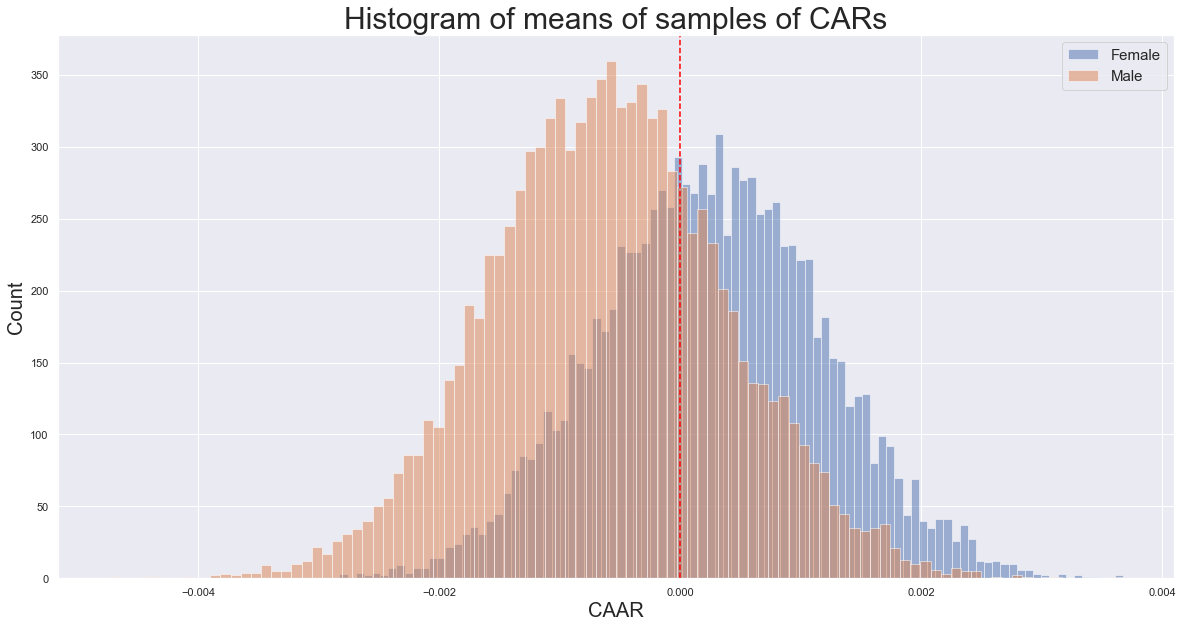

\begin{tabular}{llrr}
\toprule
            &       &  Δ CAAR &  p-value \\
Trade Type & CAR Period &         &          \\
\midrule
P - Purchase & [-20,-1] & -0.0123 &   0.8788 \\
            & [0,20] & -0.0078 &   1.4448 \\
            & [0,5] & -0.0006 &   1.4478 \\
            & [0,1] &  0.0003 &   0.6212 \\
S - Sale & [-20,-1] & -0.0044 &   0.6598 \\
            & [0,20] & -0.0057 &   0.4640 \\
            & [0,5] & -0.0018 &   0.6142 \\
            & [0,1] & -0.0008 &   0.6972 \\
S - Sale+OE & [-20,-1] & -0.0010 &   0.8560 \\
            & [0,20] &  0.0005 &   0.9214 \\
            & [0,5] & -0.0008 &   0.7770 \\
            & [0,1] & -0.0011 &   0.5712 \\
\bottomrule
\end{tabular}



In [77]:
#Recommendation Prof. Aussenegg: Simulate CAAR mean differences
RUN_statistics = True
if RUN_statistics == True:

    np.random.seed(42)

    CAR_periods=[[0, 19], [20, 40],[20, 25],[20, 21]]
    print_period = ["[-20,-1]", "[0,20]","[0,5]","[0,1]"]
    Transaction_type = ["P - Purchase", "S - Sale", "S - Sale+OE"]
         
    Dir_ttest_results = []
    ttest_index = []
    
    for type_ in Transaction_type:  
        count=0
        for cp in CAR_periods:

            print(type_)
            print(cp)

            AR_fem = ARs[(ARs['Gender'] == "Female") & (ARs['Trade Type'] == type_)& (ARs['Title'] == "Dir")].iloc[:,13:54].values
            sample_CAR_female = AR_fem[:,cp[0]:(cp[1]+1)].sum(axis=1)

            AR_male = ARs[(ARs['Gender'] == "Male") & (ARs['Trade Type'] == type_)&(ARs['Title'] == "Dir")].iloc[:,13:54].values
            sample_CAR_male= AR_male[:,cp[0]:(cp[1]+1)].sum(axis=1)

            CAAR_fem = sample_CAR_female.mean()
            CAAR_male = sample_CAR_male.mean()
            CAAR_diff = CAAR_male-CAAR_fem

            sample_size = 1500
            diffs = []
            subsample_means_CAR_female = []
            subsample_means_CAR_male = []
            for i in range(10000):
                # pick subsample
                subsample_female = np.random.choice(sample_CAR_female, sample_size, replace=True)
                subsample_male = np.random.choice(sample_CAR_male, sample_size, replace=True)
                diff = subsample_male-subsample_female
                subsample_means_CAR_female.append(subsample_female.mean())
                subsample_means_CAR_male.append(subsample_male.mean())
                diffs.append(diff.mean())

            fig = plt.figure(figsize=(20, 10))
            plt.hist(subsample_means_CAR_female,bins = 100, alpha = 0.5)
            plt.hist(subsample_means_CAR_male,bins = 100, alpha = 0.5)
            plt.legend(["Female", "Male"], fontsize = 15)
            plt.axvline(x=0.0,color="red",ls="--")
            plt.xlabel("CAAR", fontsize=20)
            plt.ylabel("Count", fontsize=20)

            plt.title("Histogram of means of samples of CARs", fontsize=30)

            plt.savefig(path+"Vis/"+"histo_Dir_"+str(cp)+"_"+str(type_)+".png", dpi=600, bbox_inches='tight')

            clear_output(wait=True)
            plt.show()

            sign = int(2*(bool(CAAR_diff<0) -0.5)) #  check for the correct side of 0.
            p_value = 2*np.mean(sign*np.asarray(diffs) > 0) #  times 2 to take into account we are looking at the interesting side always

            Dir_ttest_results.append((CAAR_diff, p_value))
            ttest_index.append((type_, str(print_period[count])))
            count+=1
            
    Dir_ttest_df = pd.DataFrame(Dir_ttest_results)
    Dir_ttest_df.columns = ["Δ CAAR", "p-value"]
    Dir_ttest_df.index =pd.MultiIndex.from_tuples(ttest_index, names=("Trade Type", "CAR Period"))
    Dir_ttest_df.to_pickle(path+"Dir_ttest_df.pkl")  
    print(ttest_CAR_df.to_latex(index=True,formatters={"name": str.upper},float_format="{:.4f}".format))
else: 
    Dir_ttest_df = pd.read_pickle(path+'Dir_ttest_df.pkl')
    print(ttest_CAR_df.to_latex(index=True,formatters={"name": str.upper},float_format="{:.4f}".format))

### CAAR vis <a class="anchor" id="vis"></a>

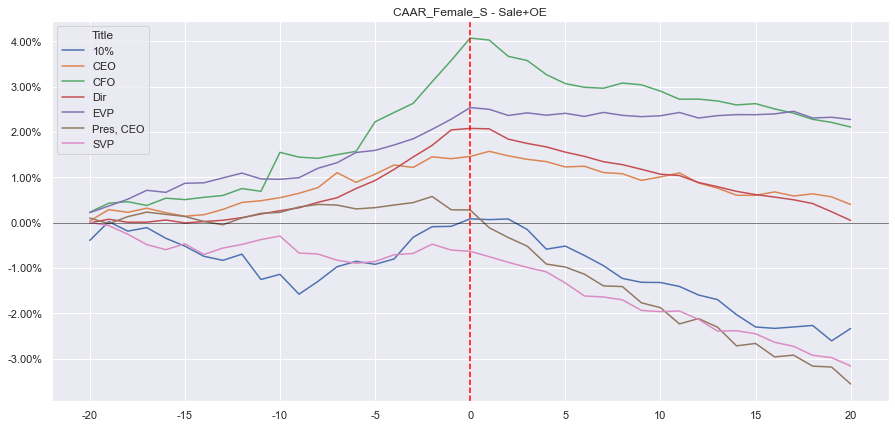

In [87]:
top_t = ["Dir","10%","CFO","Pres, CEO","SVP","EVP","CEO"]
Genders = ["Male","Female"]
Transaction_type = ["P - Purchase", "S - Sale", "S - Sale+OE"]

for gen in Genders:
    for type_ in Transaction_type:
        
        sns.set()
        sns.set(style="dark")
        sns.set(rc={'figure.figsize':(15,7)})

        fig = CARs[(CARs.Gender == gen) & (CARs["Trade Type"]==type_)&(CARs["Title"].isin(top_t))].groupby(["Title"]).mean().transpose().plot()
        fig.set_title(f'CAAR_{gen}_{type_}')
        vals = fig.get_yticks()
        fig.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
        plt.axhline(0,color="black",linewidth=0.5)
        plt.axvline(x=20,color="red",ls="--")
        plt.savefig(path+"Vis/"+f'CAAR_{gen}_{type_}'+".png", dpi=600, bbox_inches='tight')
        
        clear_output(wait=True)
        plt.show() 

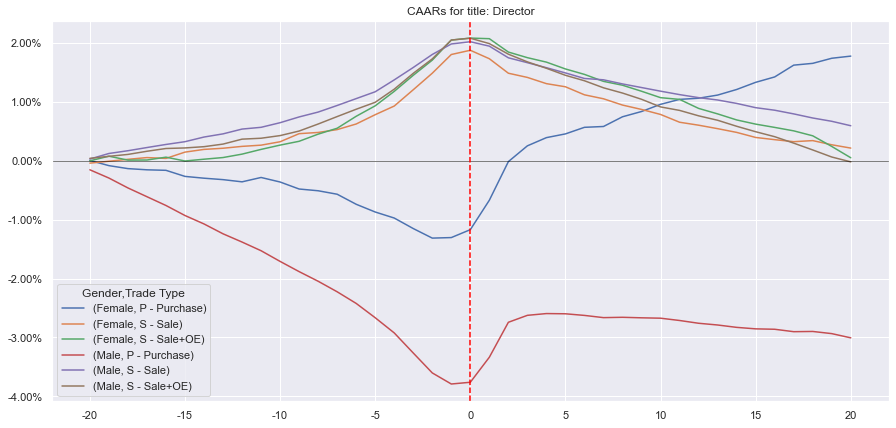

In [86]:
Genders = ["Male","Female"]
Transaction_type = ["P - Purchase", "S - Sale", "S - Sale+OE"]
        
sns.set()
sns.set(style="dark")
sns.set(rc={'figure.figsize':(15,7)})

fig = CARs[(CARs["Title"] == 'Dir')].groupby(["Gender","Trade Type"]).mean().transpose().plot()
fig.set_title('CAARs for title: Director')
vals = fig.get_yticks()
fig.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.axhline(0,color="black",linewidth=0.5)
plt.axvline(x=20,color="red",ls="--")
plt.savefig(path+"Vis/"+f'CAAR_Director'+".png", dpi=600, bbox_inches='tight')

clear_output(wait=True)
plt.show() 